# Introduction to CREsted

In this introductory notebook, we will train a topic classification model and inspect the results.

In [1]:
import sys
sys.path.insert(0, '/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages')
sys.path.insert(0,'/data/projects/c04/cbd-saerts/nkemp/software/CREsted/src')
sys.path.remove('/mnt/modules/easybuild/software/SciPy-bundle/2023.07-gfbf-2023a/lib/python3.11/site-packages')
import crested


2024-06-21 11:07:34.600504: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-21 11:07:34.640443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 11:07:35.975291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-21 11:07:37.739289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69818 MB memory:  -> device: 0, name: NV

In [2]:
import scipy
scipy

<module 'scipy' from '/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/scipy/__init__.py'>

In [3]:
adata = crested.import_bigwigs(
    bigwigs_folder='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/bigwigs/bws',
    regions_file='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/consensus_peaks_inputs.bed',
    chromsizes_file='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/mm.chrom.sizes',
    target_region_width=1000    
)
adata

2024-06-21T11:07:44.247182+0200 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end'

In [4]:
_ = crested.pp.normalize_peaks(adata, gini_std_threshold=1, top_k_percent=0.03)
adata = crested.pp.filter_regions_on_specificity(adata)

2024-06-21T11:08:10.522713+0200 INFO Filtering on top k Gini scores...
2024-06-21T11:08:16.497405+0200 INFO Added normalization weights to adata.obsm['weights']...
2024-06-21T11:08:24.938486+0200 INFO After specificity filtering, kept 88835 out of 546993 regions.


In [5]:
!nvidia-smi

Fri Jun 21 11:08:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:55:00.0 Off |                    0 |
| N/A   48C    P0            123W /  700W |   79321MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

We can use the {func}`~crested.import_topics` function to import regions per topic BED files and a consensus regions BED file (output from running [pycistopic](https://pycistopic.readthedocs.io/en/latest/) into an {class}`anndata.AnnData` object,
with the imported topics as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

Optionally, provide a chromsizes file to filter out regions that are not within the chromsizes. 

To train a model, we'll need to add a *split* column to our dataset, which we can do using `crested.pp.train_val_test_split()`.  
This will add a column to the `AnnData.obs` with the split type for each region.

In [6]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr",val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
)

# Alternatively, We can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var

split
train    71242
val       9661
test      7932
Name: count, dtype: int64


,chr,start,end,split
chr1:3093998-3096112,chr1,3093998,3096112,train
chr1:3094663-3096777,chr1,3094663,3096777,train
chr1:3112727-3114841,chr1,3112727,3114841,train
chr1:3133779-3135893,chr1,3133779,3135893,train
chr1:3164901-3167015,chr1,3164901,3167015,train
...,...,...,...,...
chrX:169824148-169826262,chrX,169824148,169826262,train
chrX:169837427-169839541,chrX,169837427,169839541,train
chrX:169838199-169840313,chrX,169838199,169840313,train
chrX:169843232-169845346,chrX,169843232,169845346,train


In [7]:
test_df = adata.var[adata.var['split']=='test']
test_df

,chr,start,end,split
chr18:3350307-3352421,chr18,3350307,3352421,test
chr18:3463977-3466091,chr18,3463977,3466091,test
chr18:3488308-3490422,chr18,3488308,3490422,test
chr18:3523881-3525995,chr18,3523881,3525995,test
chr18:3608147-3610261,chr18,3608147,3610261,test
...,...,...,...,...
chr9:124123598-124125712,chr9,124123598,124125712,test
chr9:124124762-124126876,chr9,124124762,124126876,test
chr9:124125533-124127647,chr9,124125533,124127647,test
chr9:124142793-124144907,chr9,124142793,124144907,test


In [87]:
test_df.to_csv('crested_test_set.csv')

## Fit and Evaluate

The entire CREsted workflow is built around the {func}`~crested.tl.Crested` class.
This class has a couple of required arguments:
- `data`: the {class}`~crested.tl.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`~tf.keras.Model` object containing the model architecture.
- `config`: the {class}`~crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.

#### Data

We'll start by initializing the {class}`~crested.tl.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to suuply are the `adata` object, the `genome` object, and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...)

In [8]:
from crested.tl.data import AnnDataModule

datamodule = AnnDataModule(
    adata,
    genome_file="/home/VIB.LOCAL/niklas.kempynck/nkemp/software/dev_DeepPeak/DeepPeak/data/raw/genome.fa",
    batch_size=64,
    in_memory=False,
    max_stochastic_shift=3
    
)

2024-06-21T11:08:25.359447+0200 WARNING Chromsizes file not provided when shifting. Will not check if shifted regions are within chromosomes


In [37]:
datamodule.train_dataloader

AnnDataLoader(dataset=AnnDataset(anndata_shape=(19, 440993), n_samples=881986, num_outputs=19, split=train, in_memory=False), batch_size=256, shuffle=True, one_hot_encode=True, drop_remainder=True)

In [10]:
import tensorflow as tf

#### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide any model you like.
Altneratively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.
Each of them require the width of the input sequences and the number of output classes (your `Anndata.obs`) as arguments.

For example, to use the architecture that was used to train the deepMEL, etc models, you can load the {func}`~crested.tl.zoo.deeptopic_cnn` model.

In [11]:
# Load deeptopic_cnn architecture for a dataset with 500bp regions and 80 topics
from crested.tl.zoo import chrombpnet

model_architecture = tf.keras.models.load_model("deeppeak_benchmarking/crested_norm/checkpoints/28.keras", compile=False)#chrombpnet(seq_len=2114, num_classes=19)
model_architecture

<Functional name=functional_1, built=True>

#### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`~crested.tl.default_configs` function.  

In [12]:
# Load the default configuration for training a topic classication model
from crested.tl import default_configs, TaskConfig

config = default_configs("peak_regression")
print(config)

# If you want to change some small parameters to an existing config, you can do it like this
# For example, the default learning rate is 0.001, but you want to change it to 0.0001
config.optimizer.learning_rate = 0.00001

TaskConfig(optimizer=<keras.src.optimizers.adam.Adam object at 0x7fc720127550>, loss=<crested.tl.losses._cosinemse.CosineMSELoss object at 0x7fc720079a10>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.

### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, ...).

In [13]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="deeppeak_benchmarking",
    logger="wandb",
    run_name='crested_norm_TL'
)


In [12]:
!nvidia-smi

Fri Jun 21 11:05:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:55:00.0 Off |                    0 |
| N/A   48C    P0            123W /  700W |   79323MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# train the model

import tensorflow as tf
import os
import logging

# Set logging level to only print warnings and errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress INFO and DEBUG logs

# Optionally, configure Python's logging module to suppress INFO logs
logging.getLogger('tensorflow').setLevel(logging.WARNING)

trainer.fit(epochs=50, early_stopping_patience=6, mixed_precision=False, learning_rate_reduce=True, learning_rate_reduce_patience=3)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kemp. Use `wandb login --relogin` to force relogin


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,329,875 (24.15 MB)

 Trainable params: 6,320,659 (24.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
2024-06-21T11:08:49.577146+0200 INFO Number of GPUs in use: 1
Converted call: <function _from_generator.<locals>.flat_map_fn at 0x7fc72db4be20>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x7fc72db4b920>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.generator_next_fn at 0x7fc72db4bc40>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.finalize_fn at 0x7fc72db4bce0>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function AnnDataLoader._create_dataset.<locals>.<lambda> at 0x7fc72db48720>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>, <tf.Tensor 'args_1:0' shape=(19,) dtype=float32>)
    kwargs: {}

<function AnnDataLoader._create_dataset.<locals>.<lambda> at 0x7fc72db

I0000 00:00:1718960932.762481  516896 service.cc:145] XLA service 0x7fd8e00220b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718960932.762518  516896 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2024-06-21 11:08:52.908403: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-21 11:08:53.299496: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1718960937.274719  517171 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5323', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1718960947.876593  516896 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
wandb: ERROR Unable to log learning rate.


2227/2227 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - concordance_correlation_coefficient: 0.5269 - cosine_similarity: 0.7717 - loss: -0.5819 - mean_absolute_error: 0.2536 - mean_squared_error: 0.1650 - pearson_correlation: 0.6236 - pearson_correlation_log: 0.5679 - zero_penalty_metric: 583.1575Converted call: <bound method PearsonCorrelation.reset_state of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7fc735b2ef20>>
    args: ()
    kwargs: {}

<bound method PearsonCorrelation.reset_state of <tensorflow.python.eager.polymorphic_function.tf_method_target.TfMethodTarget object at 0x7fc735b2ef20>> is not cached for subkey ConversionOptions[{}]
Converted call: <bound method KerasVariable.assign of <KerasVariable shape=(), dtype=float32, path=pearson_correlation/y_true_sum>>
    args: (0.0,)
    kwargs: None

Converted call: <bound method KerasVariable.assign of <KerasVariable shape=(), dtype=float32, path=pearson_correlation/y_pred_sum>>
    args: (0.0,

I0000 00:00:1718961084.605257  517344 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_599', 64 bytes spill stores, 64 bytes spill loads



2227/2227 ━━━━━━━━━━━━━━━━━━━━ 159s 63ms/step - concordance_correlation_coefficient: 0.5269 - cosine_similarity: 0.7717 - loss: -0.5819 - mean_absolute_error: 0.2536 - mean_squared_error: 0.1650 - pearson_correlation: 0.6236 - pearson_correlation_log: 0.5679 - zero_penalty_metric: 583.1545 - val_concordance_correlation_coefficient: 0.6198 - val_cosine_similarity: 0.8051 - val_loss: -0.6432 - val_mean_absolute_error: 0.2044 - val_mean_squared_error: 0.1371 - val_pearson_correlation: 0.6654 - val_pearson_correlation_log: 0.6275 - val_zero_penalty_metric: 504.4203 - learning_rate: 1.0000e-05
Epoch 2/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 135s 60ms/step - concordance_correlation_coefficient: 0.6390 - cosine_similarity: 0.8052 - loss: -0.6464 - mean_absolute_error: 0.2120 - mean_squared_error: 0.1341 - pearson_correlation: 0.6996 - pearson_correlation_log: 0.6202 - zero_penalty_metric: 541.3718 - val_concordance_correlation_coefficient: 0.6564 - val_cosine_similarity: 0.8091 - val_loss: -0.6461 

## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the {func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our data.

In [8]:
classes = ['Astro','Endo','L2_3IT','L5ET','L5IT','L5_6NP','L6CT','L6IT','L6b','Lamp5','Micro_PVM','OPC','Oligo','Pvalb','Sncg','Sst','Sst-Chodl','VLMC','Vip']

In [15]:
%load_ext autoreload
%autoreload 2
import crested

In [13]:
import tensorflow as tf
import os

# Set TensorFlow logging level to show only warnings and errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or '3' to show only errors

# This must be done before any TensorFlow operations are performed
tf.get_logger().setLevel('ERROR')

In [19]:
evaluator = crested.tl.Crested(data=datamodule)

# load an existing model
evaluator.load_model(
    "deeppeak_benchmarking/crested_norm/checkpoints/28.keras"
)

In [20]:
# evaluate the model on the test set
evaluator.test()

Converted call: <function _from_generator.<locals>.flat_map_fn at 0x7f88c55a0220>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x7f88c55a0040>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.generator_next_fn at 0x7f88c55a00e0>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.finalize_fn at 0x7f88c55a0180>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function AnnDataLoader._create_dataset.<locals>.<lambda> at 0x7f8df55cbf60>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>, <tf.Tensor 'args_1:0' shape=(19,) dtype=float32>)
    kwargs: {}

Converted call: <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x7f8df56fbed0>
    args: (<tf.Tens

## Predict

After training, we can also use the {meth}`~crested.tl.Crested.predict` method to predict the labels for new data and add them as a layer to the `AnnData` object.  
A common use case is to compare the predicted labels to the true labels for multiple trained models to see how well they compare.  

We can initiate a new Crested object (if you have different data) or use the existing one.  
Here we continue with the existing one since we'll use the same data as we trained on.

In [21]:
# add predictions for model 1 to the adata
evaluator.load_model(
    "deeppeak_benchmarking/crested_norm/checkpoints/28.keras"
)
adata = evaluator.predict(
    adata, model_name="crested1"
)  # adds the predictions to the adata.layers["model_1"]

Converted call: <function _from_generator.<locals>.flat_map_fn at 0x7f88c5456340>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x7f8df55cbf60>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.generator_next_fn at 0x7f88c5456200>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.finalize_fn at 0x7f88c54562a0>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function AnnDataLoader._create_dataset.<locals>.<lambda> at 0x7f88c54563e0>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>, <tf.Tensor 'args_1:0' shape=(19,) dtype=float32>)
    kwargs: {}

Converted call: <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x7f77280bfa10>
    args: (<tf.Tens

I0000 00:00:1718957295.153497  513048 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_371', 64 bytes spill stores, 64 bytes spill loads

I0000 00:00:1718957295.523855  513040 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_371', 12 bytes spill stores, 12 bytes spill loads



2137/2137 ━━━━━━━━━━━━━━━━━━━━ 122s 57ms/step
2024-06-21T10:08:21.945288+0200 INFO Adding predictions to anndata.layers[crested1].


Many of the plotting functions in the `crested.pl` module can be used to visualize the results of the model.

## Contribution Scores

We can also calculate the contribution scores for a region of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores` method.

In [22]:
# focus on two topics of interest
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores(
    ["chr18:61107668-61109782"], class_indices=[10,11]
)

# calculate the contribution scores for two regions for all topics
# scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores(['chr1:1000-1500', 'chr1:2000-2500'], class_indices=range(len(adata.obs)))

In [23]:
scores.shape

(1, 2, 2114, 4)

These can then be plotted using the {func}`~crested.pl.contribution_scores` function.

In [24]:
crested.pl.contribution_scores(
    scores, one_hot_encoded_sequences, class_names=classes, zoom_n_bases=500
)

2024-06-21T10:08:33.924299+0200 INFO Plotting contribution scores for 1 sequence(s)


IndexError: index 2 is out of bounds for axis 1 with size 2

## Plotting

TO DO

# gRelu

In [7]:
import pandas as pd
import numpy as np
test_df = pd.read_csv('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/test_ids.csv', index_col=0)
grelu_cos = np.load('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/grelu_cos.npy')
grelu_preds = np.load('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/grelu_preds.npy')
grelu_targets = np.load('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/grelu_targets.npy')

In [32]:
test_df
test_df = test_df.rename(columns={'chrom':'chr'})
test_df


chromosomes = [f'chr{i}' for i in range(1, 9)]
chromosomes+=([f'chr{i}' for i in range(10,18)])
start = np.random.randint(1, 1e6, len(chromosomes))
end = start + 2114

# Create new DataFrame with sample values
new_df = pd.DataFrame({
    'chr': chromosomes,
    'start': start,
    'end': end
})

# Concatenate the new DataFrame to the beginning of the existing DataFrame
test_df = pd.concat([new_df, test_df], ignore_index=True)
test_df.index = test_df.apply(lambda row: f"{row['chr']}:{row['start']}-{row['end']}", axis=1)

test_df.head(21)
test_df.to_csv('grelu_regs.bed', sep='\t', header=False, index=False)


In [34]:
import anndata as ad
adata_grelu = crested.import_bigwigs(
    bigwigs_folder='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/bigwigs/bws',
    regions_file='grelu_regs.bed',
    chromsizes_file='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/mm.chrom.sizes')
adata_grelu.X.shape

2024-06-19T11:30:56.731487+0200 INFO Extracting values from 19 bigWig files...
2024-06-19T11:30:59.531351+0200 WARNING 39 consensus regions have no values in any bigWig file


(19, 12658)

In [14]:
#import anndata as ad
#adata_grelu = ad.AnnData(var=test_df, X=np.zeros((len(classes),len(test_df))), obs=np.zeros((len(classes),len(test_df))))
#adata_grelu.var

/home/VIB.LOCAL/niklas.kempynck/.local/lib/python3.11/site-packages/anndata/_core/aligned_df.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name not in anno:


,chr,start,end
chr1:304013-306127,chr1,304013,306127
chr2:264568-266682,chr2,264568,266682
chr3:840915-843029,chr3,840915,843029
chr4:49627-51741,chr4,49627,51741
chr5:76422-78536,chr5,76422,78536
...,...,...,...
chr18:43800966-43803080,chr18,43800966,43803080
chr18:8662011-8664125,chr18,8662011,8664125
chr9:47990800-47992914,chr9,47990800,47992914
chr9:23628242-23630356,chr9,23628242,23630356


In [15]:
datamodule_grelu = AnnDataModule(
    adata_grelu,
    genome_file="/home/VIB.LOCAL/niklas.kempynck/nkemp/software/dev_DeepPeak/DeepPeak/data/raw/genome.fa",
    batch_size=256,
    in_memory=False
)
crested.pp.train_val_test_split(
    adata_grelu, strategy="chr", val_chroms=["chr1", "chr2"], test_chroms=["chr9", "chr18"]
)

evaluator_grelu = crested.tl.Crested(data=datamodule_grelu)
evaluator_grelu.load_model(
    "deeppeak_benchmarking/first_crested/checkpoints/26.keras"
)

In [16]:
adata_grelu_preds = evaluator_grelu.predict(
    adata_grelu, model_name="crested1"
)  # adds the predictions to the adata.layers["model_1"]

Converted call: <function _from_generator.<locals>.flat_map_fn at 0x7f260ce2c0e0>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x7f103fd5c220>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.generator_next_fn at 0x7f260f477ec0>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.finalize_fn at 0x7f260ce2c040>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function AnnDataLoader._create_dataset.<locals>.<lambda> at 0x7f260ce2c180>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=string>, <tf.Tensor 'args_1:0' shape=(19,) dtype=float32>)
    kwargs: {}

Converted call: <tensorflow.python.eager.polymorphic_function.polymorphic_function.Function object at 0x7f103bf27f10>
    args: (<tf.Tens

I0000 00:00:1718788941.660774  478264 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_371', 64 bytes spill stores, 64 bytes spill loads



50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step
2024-06-19T11:22:25.917679+0200 INFO Adding predictions to anndata.layers[crested1].


In [17]:
adata_grelu_preds[16:].shape

(12642, 19)

In [18]:
grelu_preds.shape
grelu_targets.shape

(12642, 19)

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity

x = grelu_targets#crested_targets#grelu_targets 
# Function to calculate cosine similarities for each row
def calculate_cosine_similarities(preds, targets):
    cosine_similarities = []
    for i in range(preds.shape[0]):
        cosine_sim = cosine_similarity(preds[i, :].reshape(1, -1), targets[i, :].reshape(1, -1))[0][0]
        cosine_similarities.append(cosine_sim)
    return cosine_similarities

# Calculate cosine similarities
adata_grelu_similarities = calculate_cosine_similarities(adata_grelu_preds[16:], x)
grelu_similarities = calculate_cosine_similarities(grelu_preds, x)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Cosine Similarity': adata_grelu_similarities + grelu_similarities,
    'Type': ['CREsted'] * len(adata_grelu_similarities) + ['gReLU'] * len(grelu_similarities)
})

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Type', y='Cosine Similarity', data=df)
plt.title('Cosine Similarity Distribution (gReLU targets)')
plt.show()

NameError: name 'adata_grelu_preds' is not defined

In [40]:
import seaborn as sns
def plot_correlation_heatmaps_predictions(x, predicted_values, classes, models_to_plot, log_transform=False, vmin=-1, vmax=1, fig_path=None, annot=False):
    if log_transform:
        x = np.log(x+1)
        for key in predicted_values:
            if key in models_to_plot:  # Only transform specified models
                predicted_values[key] = np.log(predicted_values[key]+1)

    n_models = len(models_to_plot)
    n_features = x.shape[1]

    # Setting up the subplot grid
    fig, axes = plt.subplots(1, n_models, figsize=(8 * n_models, 8), sharey=False)
    if n_models == 1:  # Adjust if only one model to plot for consistent indexing
        axes = [axes]

    # Iterate through each specified model's predictions
    for ax, model_name in zip(axes, models_to_plot):
        if model_name in predicted_values:
            y = predicted_values[model_name]
            # Initialize a matrix to store the correlations
            correlation_matrix = np.zeros((n_features, n_features))
            
            # Calculate the correlation for each pair of prediction-target
            for i in range(n_features):
                for j in range(n_features):
                    correlation_matrix[i, j] = np.corrcoef(x[:, i], y[:, j])[0, 1]#spearmanr(x[:, i], y[regions_ranked[i,:], j])[0]#np.corrcoef(x[regions_ranked[i,:num_regions], i], y[regions_ranked[i,:num_regions], j])[0, 1]#np.corrcoef(x[:, i], y[:, j])[0, 1]

            # Plot the heatmap on a designated subplot
            sns.heatmap(correlation_matrix, cmap='coolwarm',
                        xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax,annot=annot,
                        ax=ax)
            ax.set_title(f'Correlation Heatmap for {model_name}')
            ax.set_xlabel('Target (Peak height per cell type)')
            if ax is axes[0]:  # Only set ylabel for the first subplot to avoid repetition
                ax.set_ylabel('Prediction per cell type')

    plt.tight_layout()

    if fig_path is not None:
        plt.savefig(fig_path)
    plt.show()

In [11]:


x = grelu_targets#adata_grelu.X.T[16:]#grelu_targets
predicted_values = {'gRelu': grelu_preds, 'CREsted': adata_grelu_preds[16:], 'Targets': x}
models_to_plot = ['gRelu', 'CREsted', 'Targets']

plot_correlation_heatmaps_predictions(x, predicted_values , classes, models_to_plot, log_transform=True, vmin=-0.4, vmax=1)

NameError: name 'grelu_targets' is not defined

<BarContainer object of 19 artists>

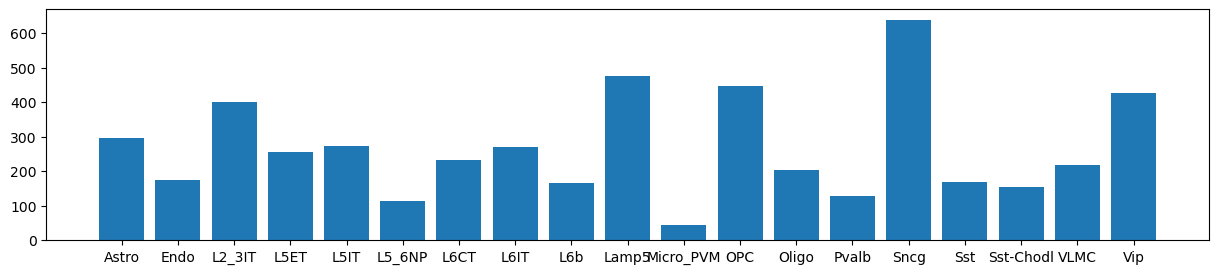

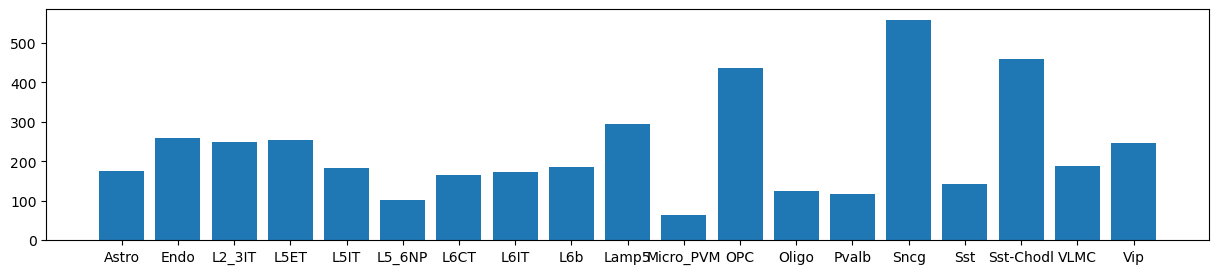

In [57]:
crested_targets = adata_grelu.X.T[16:]*1000
crested_preds = adata_grelu_preds[16:]*1000
idx=10
plt.figure(figsize=(15,3))
plt.bar(classes, grelu_targets[idx])
plt.figure(figsize=(15,3))
plt.bar(classes, crested_targets[idx])

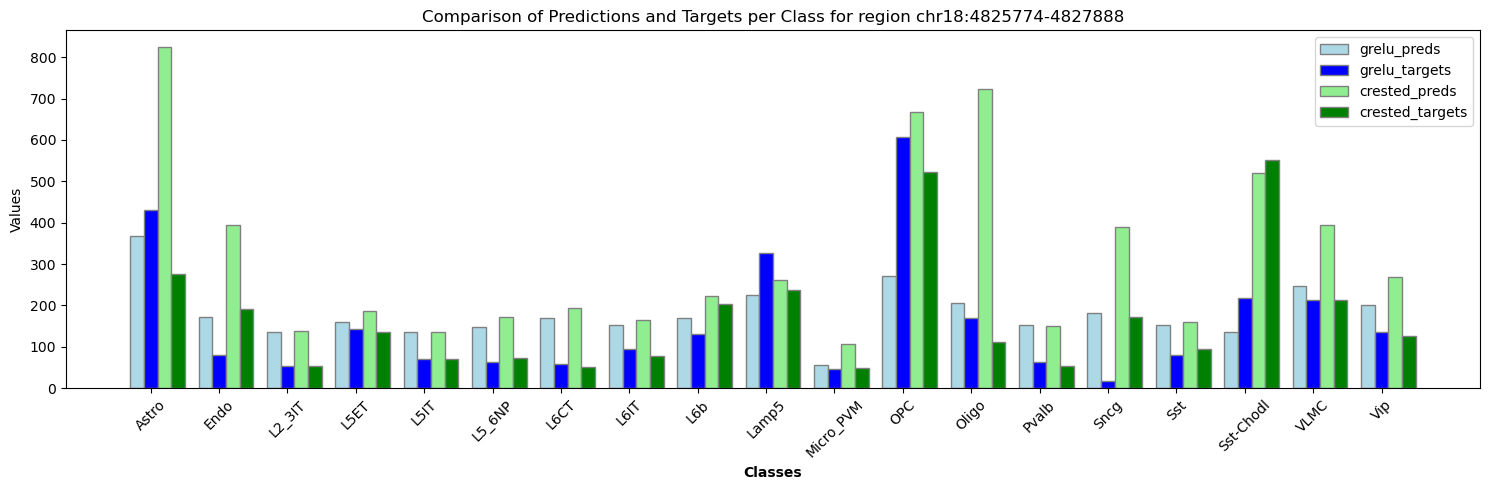

In [81]:
# Index to plot
idx = 23

# Data to plot
data = {
    'grelu_preds': grelu_preds[idx],
    'grelu_targets': grelu_targets[idx],
    'crested_preds': crested_preds[idx],
    'crested_targets': crested_targets[idx]
}

# Number of classes
n_classes = len(classes)

# Create figure and axes
plt.figure(figsize=(15, 5))

# Bar width
bar_width = 0.2

# Positions of the bars on the x-axis
r1 = np.arange(n_classes)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bars
plt.bar(r1, data['grelu_preds'], color='lightblue', width=bar_width, edgecolor='grey', label='grelu_preds')
plt.bar(r2, data['grelu_targets'], color='b', width=bar_width, edgecolor='grey', label='grelu_targets')
plt.bar(r3, data['crested_preds'], color='lightgreen', width=bar_width, edgecolor='grey', label='crested_preds')
plt.bar(r4, data['crested_targets'], color='g', width=bar_width, edgecolor='grey', label='crested_targets')

# Add labels
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_classes)], classes, rotation=45)
plt.ylabel('Values')
plt.title('Comparison of Predictions and Targets per Class for region ' + adata_grelu.var.iloc[16+idx].name)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [72]:
adata_grelu.var.iloc[0].name

'chr1:115327-117441'

<function ndarray.var>

## CREsted test set regions

In [28]:
import numpy as np
import pandas as pd
grelu_cos = np.load('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/grelu_cos_crested_testregs.npy')
grelu_preds = np.load('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/grelu_preds_crested_testregs.npy')
grelu_targets = np.load('/home/VIB.LOCAL/niklas.kempynck/nkemp/software/gReLU/docs/tutorials/grelu_targets_crested_testregs.npy')

In [27]:
adata.shape

(546993, 19)

In [12]:
chromosomes = [f'chr{i}' for i in range(1, 9)]
chromosomes+=([f'chr{i}' for i in range(10,18)])
start = np.random.randint(1, 1e6, len(chromosomes))
end = start + 2114

# Create new DataFrame with sample values
new_df = pd.DataFrame({
    'chr': chromosomes,
    'start': start,
    'end': end
})

# Concatenate the new DataFrame to the beginning of the existing DataFrame
test_df = pd.concat([new_df, test_df], ignore_index=True)
test_df.index = test_df.apply(lambda row: f"{row['chr']}:{row['start']}-{row['end']}", axis=1)

test_df.head(21)
test_df.to_csv('crested_regs.bed', sep='\t', header=False, index=False)
test_df


,chr,start,end,split
chr1:161037-163151,chr1,161037,163151,NaN
chr2:72510-74624,chr2,72510,74624,NaN
chr3:147792-149906,chr3,147792,149906,NaN
chr4:965002-967116,chr4,965002,967116,NaN
chr5:298672-300786,chr5,298672,300786,NaN
...,...,...,...,...
chr9:124441184-124443298,chr9,124441184,124443298,test
chr9:124455702-124457816,chr9,124455702,124457816,test
chr9:124475394-124477508,chr9,124475394,124477508,test
chr9:124477280-124479394,chr9,124477280,124479394,test


In [29]:
import anndata as ad
adata_crested = crested.import_bigwigs(
    bigwigs_folder='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/bigwigs/bws',
    regions_file='crested_regs.bed',
    chromsizes_file='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/mm.chrom.sizes',
    target_region_width=1000
)
_ = crested.pp.normalize_peaks(adata_crested, gini_std_threshold=1, top_k_percent=0.03)
adata_crested.X.shape

2024-06-21T10:38:52.880265+0200 INFO Extracting values from 19 bigWig files...
2024-06-21T10:38:56.444364+0200 WARNING 16 consensus regions have no values in any bigWig file
2024-06-21T10:38:57.220446+0200 INFO Filtering on top k Gini scores...
2024-06-21T10:38:57.739542+0200 INFO Added normalization weights to adata.obsm['weights']...


(19, 49952)

In [30]:
datamodule_crested = AnnDataModule(
    adata_crested,
    genome_file="/home/VIB.LOCAL/niklas.kempynck/nkemp/software/dev_DeepPeak/DeepPeak/data/raw/genome.fa",
    batch_size=256,
    in_memory=False
)
crested.pp.train_val_test_split(
    adata_crested, strategy="chr", val_chroms=["chr1", "chr2"], test_chroms=["chr9", "chr18"]
)

evaluator_crested = crested.tl.Crested(data=datamodule_crested)
evaluator_crested.load_model(
    "deeppeak_benchmarking/crested_norm/checkpoints/28.keras"
)

In [31]:
adata_crested_preds = evaluator_crested.predict(
    adata_crested, model_name="crested1"
) 

INFO:tensorflow:Converted call: <function _from_generator.<locals>.flat_map_fn at 0x7fd3b25df600>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.flat_map_fn at 0x7fd3b25df600>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x7fd3b25df100>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.get_iterator_id_fn at 0x7fd3b25df100>
    args: (<tf.Tensor 'args_0:0' shape=() dtype=int32>,)
    kwargs: {}

INFO:tensorflow:Converted call: <function _from_generator.<locals>.generator_next_fn at 0x7fd3b25dfa60>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,)
    kwargs: {}

Converted call: <function _from_generator.<locals>.generator_next_fn at 0x7fd3b25dfa60>
    args: (<tf.Tensor 'args_0:0' shape=<unknown> dtype=int64>,

In [32]:
crested_targets = adata_crested.X.T[16:]*1000
crested_preds = adata_crested_preds[16:]*1000

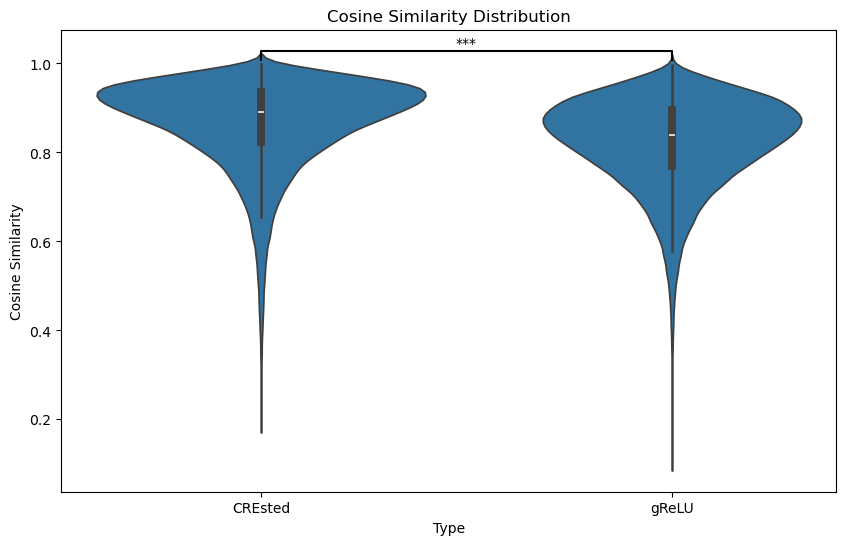

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarities for each row
def calculate_cosine_similarities(preds, targets):
    cosine_similarities = []
    for i in range(preds.shape[0]):
        cosine_sim = cosine_similarity(preds[i, :].reshape(1, -1), targets[i, :].reshape(1, -1))[0][0]
        cosine_similarities.append(cosine_sim)
    return cosine_similarities

x = crested_targets

# Calculate cosine similarities
crested_similarities = calculate_cosine_similarities(crested_preds, x)
grelu_similarities = calculate_cosine_similarities(grelu_preds, x)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Cosine Similarity': crested_similarities + grelu_similarities,
    'Type': ['CREsted'] * len(crested_similarities) + ['gReLU'] * len(grelu_similarities)
})

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(crested_similarities, grelu_similarities, alternative='two-sided')

# Determine significance level
if p_value <= 0.001:
    significance = '***'
elif p_value <= 0.01:
    significance = '**'
elif p_value <= 0.05:
    significance = '*'
else:
    significance = 'ns'  # Not significant

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Type', y='Cosine Similarity', data=df)
plt.title('Cosine Similarity Distribution')

# Add significance annotation
x1, x2 = 0, 1
y, h, col = df['Cosine Similarity'].max() + 0.01, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color=col)
plt.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', color=col)

plt.show()

In [34]:
import numpy as np
from scipy.stats import ttest_ind

# Example data
data1 =crested_similarities# Sample from a normal distribution
data2 = grelu_similarities  # Sample from a slightly different normal distribution

# Perform t-test
t_stat, p_value = ttest_ind(data1, data2)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 67.19663786825352
P-value: 0.0


In [35]:
import numpy as np
from scipy.stats import mannwhitneyu

# Example data
data1 =crested_similarities# Sample from a normal distribution
data2 = grelu_similarities  # Sample from a slightly different normal distribution

# Perform Mann-Whitney U test
u_stat, p_value = mannwhitneyu(data1, data2, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

U-statistic: 1619608637.0
P-value: 0.0


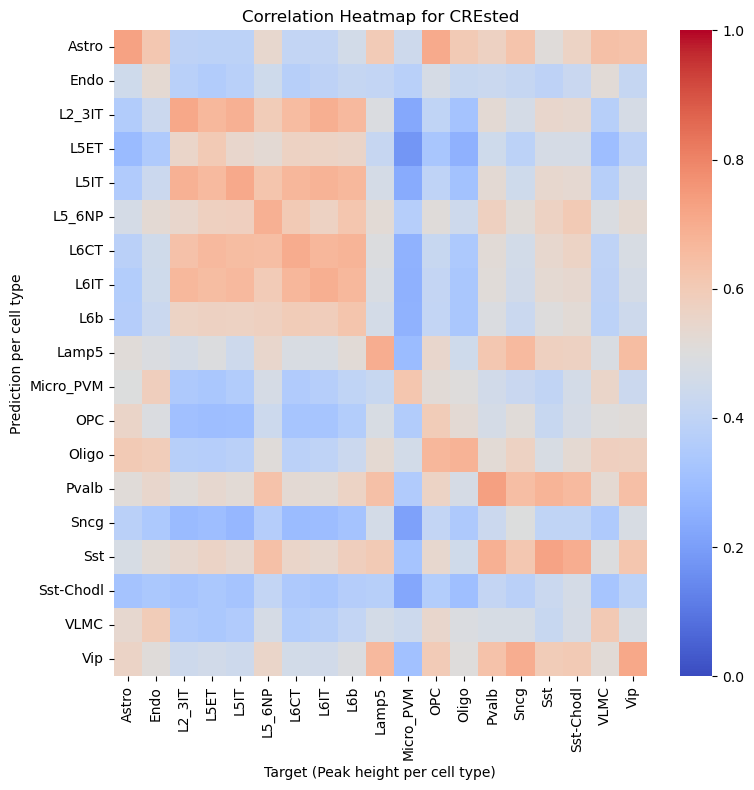

In [42]:
x = crested_targets
predicted_values = {'gRelu': grelu_preds, 'CREsted':crested_preds, 'Targets': crested_targets}
models_to_plot = ['gRelu', 'CREsted', 'Targets']
models_to_plot = ['CREsted']

plt.rcParams['svg.fonttype'] = 'none'


plot_correlation_heatmaps_predictions(x, predicted_values , classes, models_to_plot, log_transform=True, vmin=-0, vmax=1, fig_path='preds.svg', annot=False)

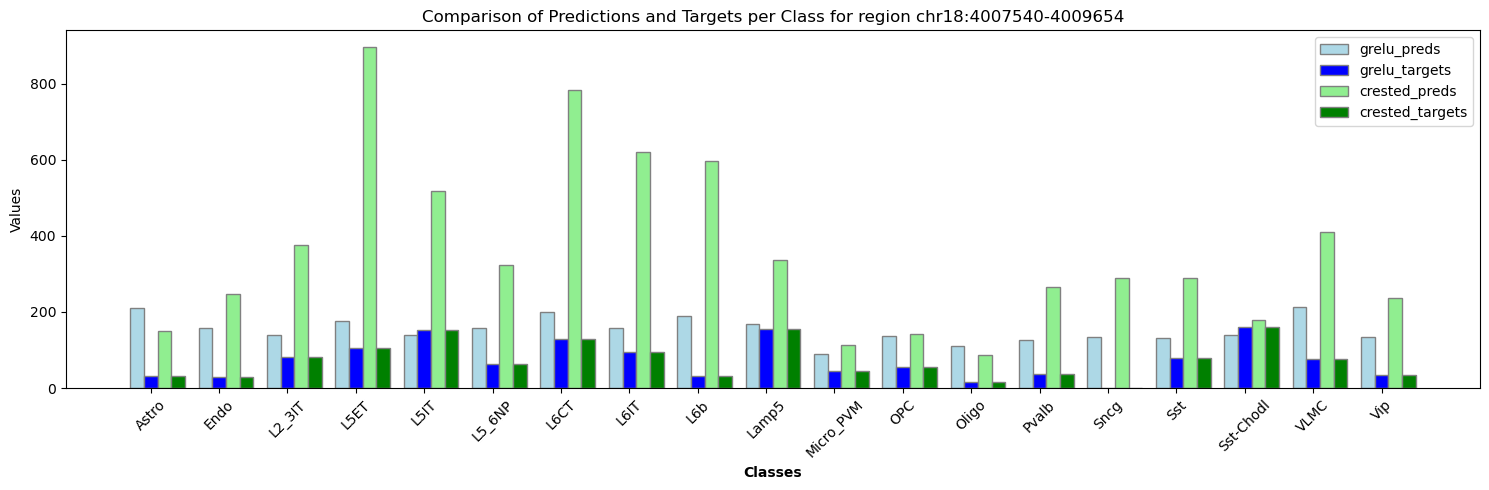

In [26]:
# Index to plot
idx = 77

# Data to plot
data = {
    'grelu_preds': grelu_preds[idx],
    'grelu_targets': grelu_targets[idx],
    'crested_preds': crested_preds[idx],
    'crested_targets': crested_targets[idx]
}

# Number of classes
n_classes = len(classes)

# Create figure and axes
plt.figure(figsize=(15, 5))

# Bar width
bar_width = 0.2

# Positions of the bars on the x-axis
r1 = np.arange(n_classes)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bars
plt.bar(r1, data['grelu_preds'], color='lightblue', width=bar_width, edgecolor='grey', label='grelu_preds')
plt.bar(r2, data['grelu_targets'], color='b', width=bar_width, edgecolor='grey', label='grelu_targets')
plt.bar(r3, data['crested_preds'], color='lightgreen', width=bar_width, edgecolor='grey', label='crested_preds')
plt.bar(r4, data['crested_targets'], color='g', width=bar_width, edgecolor='grey', label='crested_targets')

# Add labels
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_classes)], classes, rotation=45)
plt.ylabel('Values')
plt.title('Comparison of Predictions and Targets per Class for region ' + test_df.iloc[16+idx].name)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

## BigWig testing

In [22]:
import pybigtools
pybigtools.bigWigAverageOverBed()

TypeError: bigWigAverageOverBed() missing 2 required positional arguments: 'bigwig' and 'bed'

In [24]:
pybigtools

<module 'pybigtools' from '/home/VIB.LOCAL/niklas.kempynck/.conda/envs/crested/lib/python3.11/site-packages/pybigtools/__init__.py'>

In [6]:
import pyBigWig
import os
bw_dir_mm='/home/VIB.LOCAL/niklas.kempynck/nkemp/mouse/biccn/bigwigs/bws/'
bws_mm = os.listdir(bw_dir_mm)
bws_mm = np.sort(bws_mm)
bw_list_mm = []
for bw_file in bws_mm:
    print(bw_file)
    bw = pyBigWig.open(bw_dir_mm+bw_file)
    bw_list_mm.append(bw)


Astro.bw
Endo.bw
L2_3IT.bw
L5ET.bw
L5IT.bw
L5_6NP.bw
L6CT.bw
L6IT.bw
L6b.bw
Lamp5.bw
Micro_PVM.bw
OPC.bw
Oligo.bw
Pvalb.bw
Sncg.bw
Sst.bw
SstChodl.bw
VLMC.bw
Vip.bw


In [27]:
import pyBigWig

gt = np.zeros(19)
for i, bw in enumerate(bw_list_mm):  
    # Retrieve values from the bigWig file for the given interval
    #gt[i] = np.sum(np.nan_to_num(bw.values('chr18', 3901975+557, 3904089-557)))
    gt[i] = np.sum(bw.values('chr18', 3901975+557, 3904089-557))



# Print the values
print(gt)

[127.51823128          nan  67.84573755          nan  86.07774401
          nan  58.69914936  59.43569539          nan  81.8317229
          nan          nan  53.36263852  63.99130476          nan
          nan          nan          nan 262.68860076]


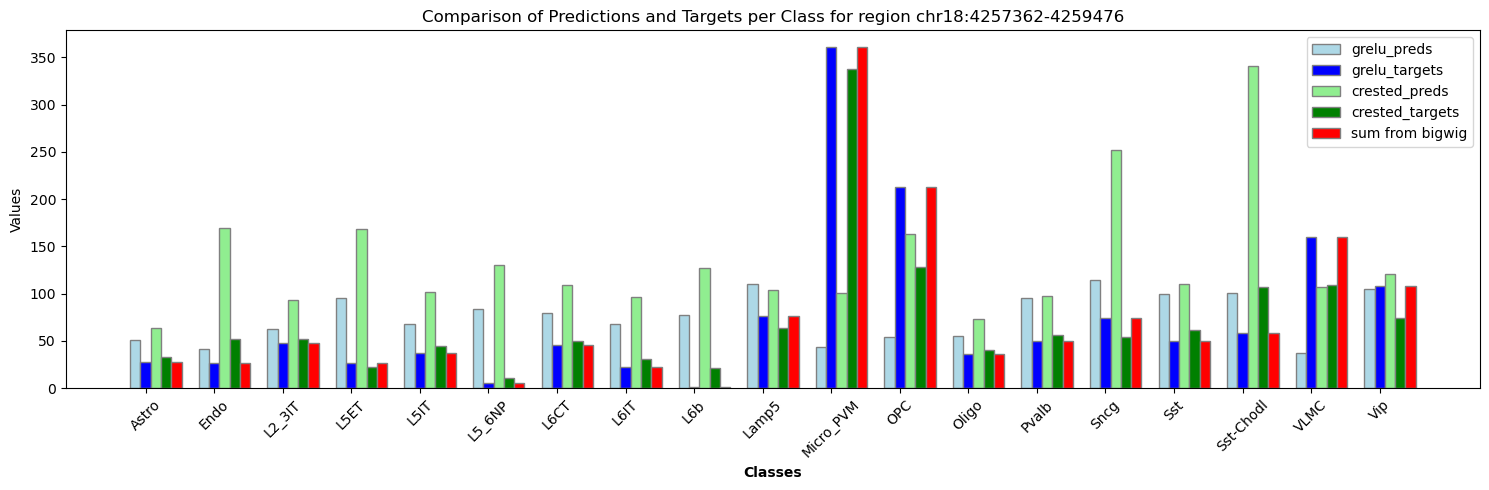

In [24]:
# Index to plot
idx = 100

import pyBigWig

gt = np.zeros(19)
for i, bw in enumerate(bw_list_mm):  
    # Retrieve values from the bigWig file for the given interval
    gt[i] = np.sum(np.nan_to_num(bw.values(test_df.iloc[16+idx]['chr'], int(test_df.iloc[16+idx]['start'])+557, int(test_df.iloc[16+idx]['end'])-557)))




# Data to plot
data = {
    'grelu_preds': grelu_preds[idx],
    'grelu_targets': grelu_targets[idx],
    'crested_preds': crested_preds[idx],
    'crested_targets': crested_targets[idx],
    'sum from bigwig':gt,
}

# Number of classes
n_classes = len(classes)

# Create figure and axes
plt.figure(figsize=(15, 5))

# Bar width
bar_width = 0.15

# Positions of the bars on the x-axis
r1 = np.arange(n_classes)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]


# Create the bars
plt.bar(r1, data['grelu_preds'], color='lightblue', width=bar_width, edgecolor='grey', label='grelu_preds')
plt.bar(r2, data['grelu_targets'], color='b', width=bar_width, edgecolor='grey', label='grelu_targets')
plt.bar(r3, data['crested_preds'], color='lightgreen', width=bar_width, edgecolor='grey', label='crested_preds')
plt.bar(r4, data['crested_targets'], color='g', width=bar_width, edgecolor='grey', label='crested_targets')
plt.bar(r5, data['sum from bigwig'], color='r', width=bar_width, edgecolor='grey', label='sum from bigwig')


# Add labels
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_classes)], classes, rotation=45)
plt.ylabel('Values')
plt.title('Comparison of Predictions and Targets per Class for region ' + test_df.iloc[16+idx].name)

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()